### Data Preparation
Importing necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statsmodels.stats.api as sms

Loading the data

In [2]:
# Function to load a CSV file into a pandas DataFrame.
def load_data(filepath):
    df = pd.read_csv(filepath)
    return df

In [3]:
df = load_data('data/CustomerSegmentation_Dec_May.csv')
df.head()

,FLTDATE,TKTNUM,FULLNAME,COUPON_NO,UNIQUEKEY,PHONE_NO,EMAIL,ORIG_AIRPORT,DEST_AIRPORT,CABINCLASS,FARE_CURRENCY,LOCAL_FARE
0,06-DEC-24,7062306512967,SAMUEL JAIRO OMINDO,1.0,1993127SAMUELJAIROOMINDO,254726066315,business@genteel.co.ke,NBO,MBA,Economy,USD,38.00
1,02-DEC-24,7062306470726,STEPHEN MAMBO,1.0,1985910STEPHENMAMBO,254721379706,steve.mambo@gmail.com,NBO,EBB,Economy,USD,210.00
2,07-DEC-24,7062306522753,NOKQWECE TLAKALI MAHALEFELE,2.0,1984921NOKQWECETLAKALIMAHALEFELE,26663552080,selialiaf@outlook.com,NBO,JNB,Economy,USD,383.00
3,03-JAN-25,7063490291461,MEMORY MUKUDOKA,2.0,1982417MEMORYMUKUDOKA,263775674733,memorymukudokawashaya@gmail.com,HRE,NBO,Business,USD,479.00
4,29-DEC-24,7063424501197,MANISH TUKARAM CHILE,2.0,198468MANISHTUKARAMCHILE,918291041284,wegahtatrvl@gmail.com,NBO,EBB,Economy,USD,146.16


#### Data Cleaning

In [4]:
def clean_dataframe(df):
    """
    Cleans the given DataFrame by:
    1. Dropping unnecessary columns if they exist.
    2. Checking and logging the number of duplicate rows.
    3. Checking and logging missing values.
    4. Removing rows where 'LOCAL_FARE' is 0.
    5. Converting 'FLTDATE' to datetime format.

    Returns:
        df_cleaned (pd.DataFrame): The cleaned DataFrame.
    """
    # Define columns to drop
    drop_cols = ['FARE_CURRENCY']

    # Drop specified columns if they exist
    existing_cols = [col for col in drop_cols if col in df.columns]
    df.drop(columns=existing_cols, inplace=True)
    print(f"Dropped columns: {existing_cols}")

    # Check for duplicates
    duplicates = df.duplicated().sum()
    df = df.drop_duplicates()
    print(f"Dropped {duplicates} duplicate rows.")

    # Check for missing values
    missing_values = df.isnull().sum()
    print("Missing values in each column:\n", missing_values)

    # Drop rows where LOCAL_FARE is 0
    df_cleaned = df[df["LOCAL_FARE"] != 0]
    print(f"Final DataFrame shape after cleaning: {df_cleaned.shape}")

    # Convert 'FLTDATE' to datetime format
    df_cleaned["FLTDATE"] = pd.to_datetime(df_cleaned["FLTDATE"], errors="coerce")
    print("Converted 'FLTDATE' to datetime format.")

    return df_cleaned


In [5]:
# calling the cleaning function
df_cleaned = clean_dataframe(df)

Dropped columns: ['FARE_CURRENCY']
Dropped 0 duplicate rows.
Missing values in each column:
 FLTDATE          0
TKTNUM           0
FULLNAME         0
COUPON_NO       50
UNIQUEKEY        0
PHONE_NO         0
EMAIL            5
ORIG_AIRPORT     0
DEST_AIRPORT     0
CABINCLASS       0
LOCAL_FARE       0
dtype: int64
Final DataFrame shape after cleaning: (396896, 11)
Converted 'FLTDATE' to datetime format.


C:\Users\lynn.oloo\AppData\Local\Temp\ipykernel_27808\2284230886.py:35: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_cleaned["FLTDATE"] = pd.to_datetime(df_cleaned["FLTDATE"], errors="coerce")
C:\Users\lynn.oloo\AppData\Local\Temp\ipykernel_27808\2284230886.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned["FLTDATE"] = pd.to_datetime(df_cleaned["FLTDATE"], errors="coerce")


In [6]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 396896 entries, 0 to 407562
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   FLTDATE       396896 non-null  datetime64[ns]
 1   TKTNUM        396896 non-null  int64         
 2   FULLNAME      396896 non-null  object        
 3   COUPON_NO     396848 non-null  float64       
 4   UNIQUEKEY     396896 non-null  object        
 5   PHONE_NO      396896 non-null  int64         
 6   EMAIL         396891 non-null  object        
 7   ORIG_AIRPORT  396896 non-null  object        
 8   DEST_AIRPORT  396896 non-null  object        
 9   CABINCLASS    396896 non-null  object        
 10  LOCAL_FARE    396896 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 36.3+ MB


### Exploratory Data Analysis

In [7]:
# Describe the Numeric Data
df_cleaned['LOCAL_FARE'].describe()

count    396896.000000
mean        496.622767
std         593.830728
min           1.000000
25%         154.000000
50%         318.000000
75%         612.000000
max       16380.000000
Name: LOCAL_FARE, dtype: float64

#### outliers

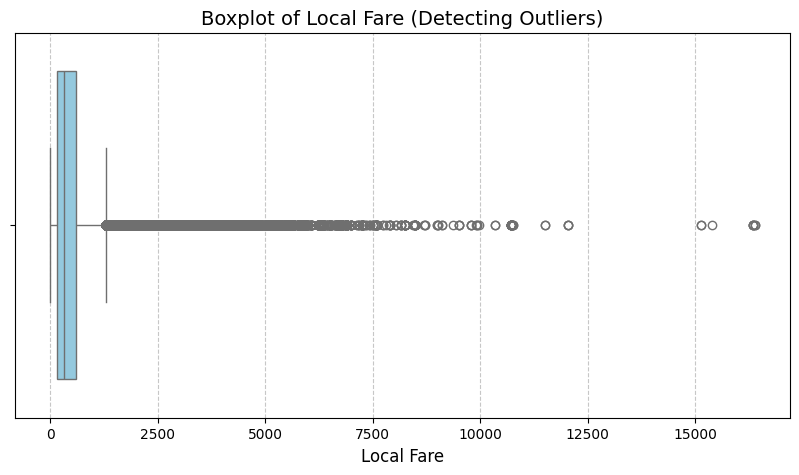

In [8]:
plt.figure(figsize=(10, 5))  # Adjust figure size
sns.boxplot(x=df_cleaned['LOCAL_FARE'], color="skyblue", showfliers=True)  # Show outliers
plt.xlabel("Local Fare", fontsize=12)
plt.title("Boxplot of Local Fare (Detecting Outliers)", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



#### Trend Analysis

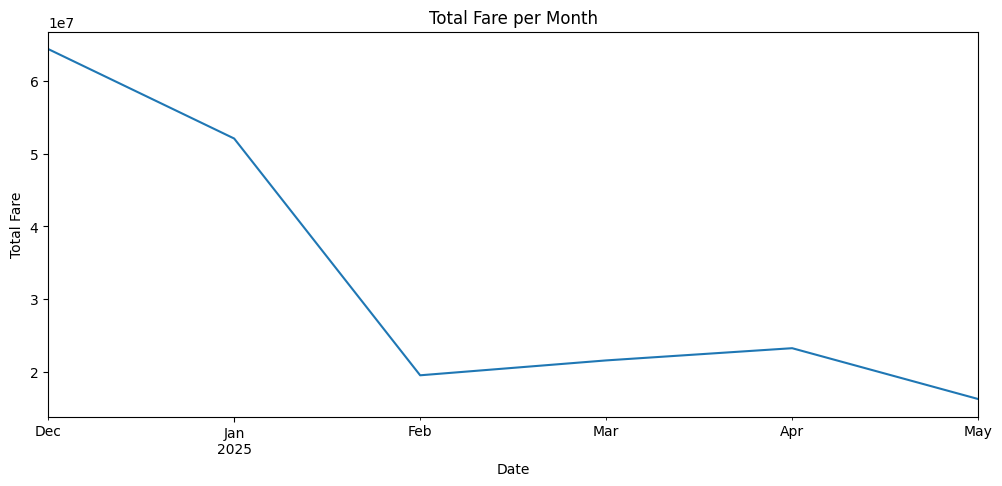

In [9]:
df_cleaned.set_index('FLTDATE', inplace=True)  # Set date as index

# Plot fare trends
df_cleaned['LOCAL_FARE'].resample('ME').sum().plot(figsize=(12,5), title="Total Fare per Month")
plt.xlabel("Date")
plt.ylabel("Total Fare")
plt.show()

<Axes: xlabel='Month'>

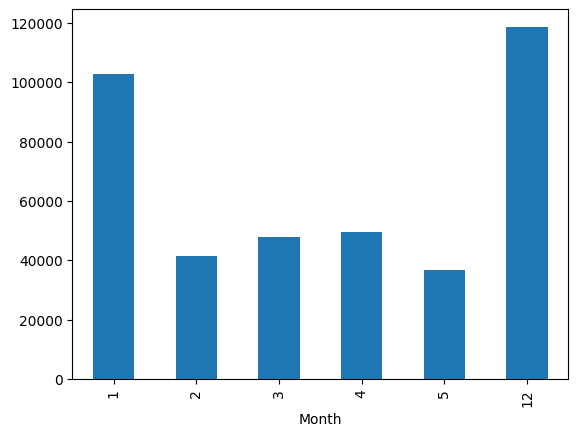

In [10]:
df_cleaned = df_cleaned.reset_index()  #  FLTDATE was set as index, reset it
#Find peak booking seasons and trends over months
df_cleaned['Month'] = df_cleaned['FLTDATE'].dt.month  
df_cleaned.groupby("Month")["LOCAL_FARE"].count().plot(kind="bar")

### Feature Engineering

Recency (R): How recently a customer booked a flight.

Frequency (F): How many times a customer has booked.

Monetary (M): Total amount spent by each customer.

Length (L): Duration between the first and latest booking.

In [11]:
def compute_LRFM(df, date_column="FLTDATE", customer_id="UNIQUEKEY", fare_column="LOCAL_FARE", name_column="FULLNAME",phone_column="PHONE_NO",email_column="EMAIL",origin_column="ORIG_AIRPORT",dest_column="DEST_AIRPORT",cabin_column="CABINCLASS"):
    """
    Compute LRFM (Length, Recency, Frequency, Monetary) for customer segmentation.
    
    Parameters:
    df (DataFrame): The cleaned dataframe.
    date_column (str): Column name representing the transaction date.
    customer_id (str): Column name representing the customer ID.
    fare_column (str): Column name representing the monetary value of transactions.
    name_column (str): Column name representing the customer's full name.

    Returns:
    DataFrame: The dataframe with added LRFM columns, including full names (1 row per unique customer).
    """
    # Ensure date column is in datetime format
    df[date_column] = pd.to_datetime(df[date_column])

    # Set reference date for recency calculation
    today = pd.to_datetime("01-JUNE-25")

    # Compute LRFM metrics grouped by customer_id
    lrfm_df = df.groupby(customer_id).agg(
        Full_Name=(name_column, "first"),
        Phone_No=(phone_column, "first"),
        Email=(email_column, "first"), 
        Cabin=(cabin_column, "first"), 
        Origin=(origin_column, "first"), 
        Destination=(dest_column, "first"), 
        Last_Purchase_Date=(date_column, "max"),
        First_Purchase_Date=(date_column, "min"),
        Frequency=(date_column, "count"),
        Monetary=(fare_column, "sum")
    ).reset_index()

    # Compute Recency (days since last purchase)
    lrfm_df["Recency"] = (today - lrfm_df["Last_Purchase_Date"]).dt.days

    # Compute Length (days between first and last purchase)
    lrfm_df["Length"] = (lrfm_df["Last_Purchase_Date"] - lrfm_df["First_Purchase_Date"]).dt.days

    print("LRFM computation completed.")

    return lrfm_df


In [12]:
# Compute LRFM
df_cleaned = compute_LRFM(df_cleaned)
df_cleaned

LRFM computation completed.


,UNIQUEKEY,Full_Name,Phone_No,Email,Cabin,Origin,Destination,Last_Purchase_Date,First_Purchase_Date,Frequency,Monetary,Recency,Length
0,18741222MOROGOLULEI,MOROGO LULEI,254723772315,riftventurestravelsafaris@gmail.com,Economy,EDL,NBO,2024-12-14,2024-12-14,1,31.0,169,0
1,1875103SALADBORUGURACHA,SALAD BORU GURACHA,254700359516,armyner2003@gmail.com,Economy,MBA,NBO,2025-02-17,2025-02-17,1,99.0,104,0
2,1875222MERCYLYNATECHEPKIRUI,MERCYLYNATE CHEPKIRUI,254723379543,xtinekendele@gmail.com,Economy,MBA,NBO,2025-03-01,2025-03-01,1,84.0,92,0
3,187534MARIANAUDE,MARIA NAUDE,27825634096,miana@technvst.co,Economy,NBO,ZNZ,2024-12-05,2024-12-05,1,161.0,178,0
4,1875429DUNCANOTTOMA,DUNCAN OTTOMA,254723478695,otomaduncan@gmail.com,Economy,NBO,MBA,2025-04-23,2025-04-23,1,104.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
169545,20241113JONATHANGATHIA,JONATHAN GATHIA,254718876522,travel@dreamzworldgroup.com,Economy,MBA,NBO,2024-12-13,2024-12-02,2,244.0,170,11
169546,2024122JONATHANNDUNGU,JONATHAN NDUNGU,254718876522,travel@dreamzworldgroup.com,Economy,NBO,MBA,2024-12-13,2024-12-02,2,244.0,170,11
169547,2024327ALTAFFARIDUNABDALLA,ALTAF FARIDUN ABDALLA,254722516652,altaf.abdalla@uniquegroup.co.ke,Economy,DAR,NBO,2025-04-24,2025-04-24,2,280.0,38,0
169548,2024515ATAARSLANKARA,ATA ARSLAN KARA,255767159610,chefalikara@yahoo.com,Economy,DAR,NBO,2024-12-05,2024-12-05,2,246.0,178,0


Normalization of the parameters

In [13]:
def normalize_lrfm(df, columns=['Recency', 'Length', 'Frequency', 'Monetary']):
    """
    Normalizes the LRFM features.
    - Recency is scaled inversely (1 - scaled value).
    - Other features (Length, Frequency, Monetary) are scaled normally.

    Parameters:
    df (pd.DataFrame): The dataframe containing LRFM columns.
    columns (list): The list of columns to normalize.

    Returns:
    pd.DataFrame: A dataframe with normalized LRFM values.
    """
    for col in columns:
        min_val = df[col].min()
        max_val = df[col].max()

        if min_val != max_val:  # Avoid division by zero
            df[f"{col}_norm"] = (df[col] - min_val) / (max_val - min_val)
        else:
            df[f"{col}_norm"] = 0  # If all values are the same, set to 0

    # Apply inverse scaling for Recency
    df["Recency_norm"] = 1 - df["Recency_norm"]
    print("LRFM normalization completed.")

    return df


In [14]:
# normalize the parameters
df_cleaned = normalize_lrfm(df_cleaned)
df_cleaned.head()

LRFM normalization completed.


,UNIQUEKEY,Full_Name,Phone_No,Email,Cabin,Origin,Destination,Last_Purchase_Date,First_Purchase_Date,Frequency,Monetary,Recency,Length,Recency_norm,Length_norm,Frequency_norm,Monetary_norm
0,18741222MOROGOLULEI,MOROGO LULEI,254723772315,riftventurestravelsafaris@gmail.com,Economy,EDL,NBO,2024-12-14,2024-12-14,1,31.0,169,0,0.078788,0.0,0.0,0.000428
1,1875103SALADBORUGURACHA,SALAD BORU GURACHA,254700359516,armyner2003@gmail.com,Economy,MBA,NBO,2025-02-17,2025-02-17,1,99.0,104,0,0.472727,0.0,0.0,0.001469
2,1875222MERCYLYNATECHEPKIRUI,MERCYLYNATE CHEPKIRUI,254723379543,xtinekendele@gmail.com,Economy,MBA,NBO,2025-03-01,2025-03-01,1,84.0,92,0,0.545455,0.0,0.0,0.001239
3,187534MARIANAUDE,MARIA NAUDE,27825634096,miana@technvst.co,Economy,NBO,ZNZ,2024-12-05,2024-12-05,1,161.0,178,0,0.024242,0.0,0.0,0.002417
4,1875429DUNCANOTTOMA,DUNCAN OTTOMA,254723478695,otomaduncan@gmail.com,Economy,NBO,MBA,2025-04-23,2025-04-23,1,104.0,39,0,0.866667,0.0,0.0,0.001545


In [15]:
def compute_quintiles(df, columns):
    """
    Computes the quintile cutoffs (25th, 50th, 75th percentiles) for normalized LRFM values.
    """
    quintiles = {}
    for col in columns:
        quintiles[col] = {
            0.25: df[col].quantile(0.25),
            0.50: df[col].quantile(0.50),
            0.75: df[col].quantile(0.75)
        }
    return quintiles

def lrfm_score(x, c, quintiles):
    """
    Assigns a score (1-4) to a given normalized LRFM value based on quintiles.
    """
    if x <= quintiles[c][0.25]:
        return 1
    elif x <= quintiles[c][0.50]:
        return 2
    elif x <= quintiles[c][0.75]:
        return 3
    else:
        return 4

def assign_lrfm_scores(df):
    """
    Assigns LRFM scores (1-4) based on normalized values.
    """
    columns = ['Recency_norm', 'Length_norm', 'Frequency_norm', 'Monetary_norm']
    quintiles = compute_quintiles(df, columns)

    # Assign scores
    df['R'] = df['Recency_norm'].apply(lambda x: lrfm_score(x, 'Recency_norm', quintiles))
    df['L'] = df['Length_norm'].apply(lambda x: lrfm_score(x, 'Length_norm', quintiles))
    df['F'] = df['Frequency_norm'].apply(lambda x: lrfm_score(x, 'Frequency_norm', quintiles))
    df['M'] = df['Monetary_norm'].apply(lambda x: lrfm_score(x, 'Monetary_norm', quintiles))

    # Combine scores into a single LRFM string
    df['LRFM Score'] = df['L'].astype(str) + df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)

    print("LRFM scoring completed.")

    return df


In [16]:
# Assign scores
df_cleaned = assign_lrfm_scores(df_cleaned)
df_cleaned

LRFM scoring completed.


,UNIQUEKEY,Full_Name,Phone_No,Email,Cabin,Origin,Destination,Last_Purchase_Date,First_Purchase_Date,Frequency,...,Length,Recency_norm,Length_norm,Frequency_norm,Monetary_norm,R,L,F,M,LRFM Score
0,18741222MOROGOLULEI,MOROGO LULEI,254723772315,riftventurestravelsafaris@gmail.com,Economy,EDL,NBO,2024-12-14,2024-12-14,1,...,0,0.078788,0.000000,0.000000,0.000428,1,1,1,1,1111
1,1875103SALADBORUGURACHA,SALAD BORU GURACHA,254700359516,armyner2003@gmail.com,Economy,MBA,NBO,2025-02-17,2025-02-17,1,...,0,0.472727,0.000000,0.000000,0.001469,3,1,1,1,1311
2,1875222MERCYLYNATECHEPKIRUI,MERCYLYNATE CHEPKIRUI,254723379543,xtinekendele@gmail.com,Economy,MBA,NBO,2025-03-01,2025-03-01,1,...,0,0.545455,0.000000,0.000000,0.001239,3,1,1,1,1311
3,187534MARIANAUDE,MARIA NAUDE,27825634096,miana@technvst.co,Economy,NBO,ZNZ,2024-12-05,2024-12-05,1,...,0,0.024242,0.000000,0.000000,0.002417,1,1,1,1,1111
4,1875429DUNCANOTTOMA,DUNCAN OTTOMA,254723478695,otomaduncan@gmail.com,Economy,NBO,MBA,2025-04-23,2025-04-23,1,...,0,0.866667,0.000000,0.000000,0.001545,4,1,1,1,1411
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169545,20241113JONATHANGATHIA,JONATHAN GATHIA,254718876522,travel@dreamzworldgroup.com,Economy,MBA,NBO,2024-12-13,2024-12-02,2,...,11,0.072727,0.066667,0.016393,0.003687,1,4,2,2,4122
169546,2024122JONATHANNDUNGU,JONATHAN NDUNGU,254718876522,travel@dreamzworldgroup.com,Economy,NBO,MBA,2024-12-13,2024-12-02,2,...,11,0.072727,0.066667,0.016393,0.003687,1,4,2,2,4122
169547,2024327ALTAFFARIDUNABDALLA,ALTAF FARIDUN ABDALLA,254722516652,altaf.abdalla@uniquegroup.co.ke,Economy,DAR,NBO,2025-04-24,2025-04-24,2,...,0,0.872727,0.000000,0.016393,0.004238,4,1,2,2,1422
169548,2024515ATAARSLANKARA,ATA ARSLAN KARA,255767159610,chefalikara@yahoo.com,Economy,DAR,NBO,2024-12-05,2024-12-05,2,...,0,0.024242,0.000000,0.016393,0.003718,1,1,2,2,1122


AHP to get weights and calculate the customer lifetime value

In [17]:
def compute_clv(df):
    """
    Computes Customer Lifetime Value (CLV) using AHP weights.

    Parameters:
    df (pd.DataFrame): DataFrame containing normalized Recency, Length, Frequency, and Monetary columns.

    Returns:
    pd.DataFrame: Updated DataFrame with a new CLV column.
    """
    # Define the weights
    weights = {
        "Recency": 0.2287,
        "Length": 0.1290,
        "Frequency": 0.2826,
        "Monetary": 0.3597
    }

    # Compute CLV
    df["CLV"] = (
        df["Recency_norm"] * weights["Recency"] +
        df["Length_norm"] * weights["Length"] +
        df["Frequency_norm"] * weights["Frequency"] +
        df["Monetary_norm"] * weights["Monetary"]
    )

    print("CLV computation completed.")

    return df


In [18]:
# compute the customer life time value
df_cleaned = compute_clv(df_cleaned)
df_cleaned.head()


CLV computation completed.


,UNIQUEKEY,Full_Name,Phone_No,Email,Cabin,Origin,Destination,Last_Purchase_Date,First_Purchase_Date,Frequency,...,Recency_norm,Length_norm,Frequency_norm,Monetary_norm,R,L,F,M,LRFM Score,CLV
0,18741222MOROGOLULEI,MOROGO LULEI,254723772315,riftventurestravelsafaris@gmail.com,Economy,EDL,NBO,2024-12-14,2024-12-14,1,...,0.078788,0.0,0.0,0.000428,1,1,1,1,1111,0.018173
1,1875103SALADBORUGURACHA,SALAD BORU GURACHA,254700359516,armyner2003@gmail.com,Economy,MBA,NBO,2025-02-17,2025-02-17,1,...,0.472727,0.0,0.0,0.001469,3,1,1,1,1311,0.108641
2,1875222MERCYLYNATECHEPKIRUI,MERCYLYNATE CHEPKIRUI,254723379543,xtinekendele@gmail.com,Economy,MBA,NBO,2025-03-01,2025-03-01,1,...,0.545455,0.0,0.0,0.001239,3,1,1,1,1311,0.125191
3,187534MARIANAUDE,MARIA NAUDE,27825634096,miana@technvst.co,Economy,NBO,ZNZ,2024-12-05,2024-12-05,1,...,0.024242,0.0,0.0,0.002417,1,1,1,1,1111,0.006414
4,1875429DUNCANOTTOMA,DUNCAN OTTOMA,254723478695,otomaduncan@gmail.com,Economy,NBO,MBA,2025-04-23,2025-04-23,1,...,0.866667,0.0,0.0,0.001545,4,1,1,1,1411,0.198763


Clustering using kmeans

Silhouette Score for 4 clusters: 0.5801


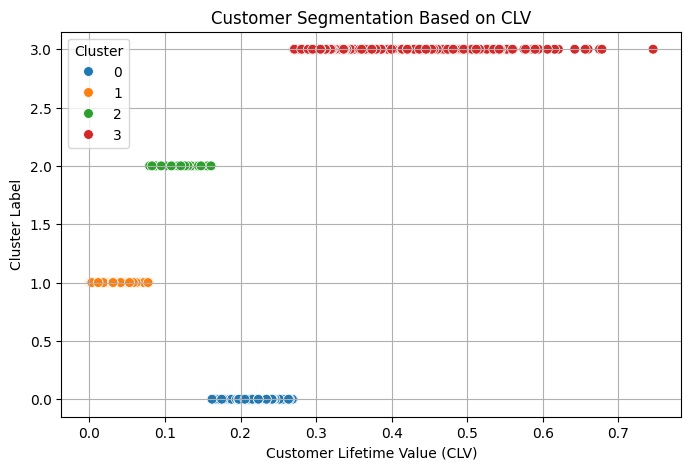

In [19]:
# Define fixed number of clusters
k = 4

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cleaned['cluster'] = kmeans.fit_predict(df_cleaned[['CLV']])

# Evaluate clustering with silhouette score
silhouette = silhouette_score(df_cleaned[['CLV']], df_cleaned['cluster'])
print(f"Silhouette Score for {k} clusters: {silhouette:.4f}")

# Plot Cluster Distribution
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_cleaned['CLV'], y=df_cleaned['cluster'], hue=df_cleaned['cluster'], palette="tab10", s=50)
plt.xlabel("Customer Lifetime Value (CLV)")
plt.ylabel("Cluster Label")
plt.title("Customer Segmentation Based on CLV")
plt.grid(True)
plt.legend(title="Cluster")
plt.show()


In [20]:
cluster_names = {
    0: "High Value Frequent Customers",
    2: "Potential Loyal Flyers",
    1: "At Risk Explorers",
    3: "Premium customers"
}

# Rename clusters
df_cleaned["segment"] = df_cleaned["cluster"].map(cluster_names)
df_cleaned

,UNIQUEKEY,Full_Name,Phone_No,Email,Cabin,Origin,Destination,Last_Purchase_Date,First_Purchase_Date,Frequency,...,Frequency_norm,Monetary_norm,R,L,F,M,LRFM Score,CLV,cluster,segment
0,18741222MOROGOLULEI,MOROGO LULEI,254723772315,riftventurestravelsafaris@gmail.com,Economy,EDL,NBO,2024-12-14,2024-12-14,1,...,0.000000,0.000428,1,1,1,1,1111,0.018173,1,At Risk Explorers
1,1875103SALADBORUGURACHA,SALAD BORU GURACHA,254700359516,armyner2003@gmail.com,Economy,MBA,NBO,2025-02-17,2025-02-17,1,...,0.000000,0.001469,3,1,1,1,1311,0.108641,2,Potential Loyal Flyers
2,1875222MERCYLYNATECHEPKIRUI,MERCYLYNATE CHEPKIRUI,254723379543,xtinekendele@gmail.com,Economy,MBA,NBO,2025-03-01,2025-03-01,1,...,0.000000,0.001239,3,1,1,1,1311,0.125191,2,Potential Loyal Flyers
3,187534MARIANAUDE,MARIA NAUDE,27825634096,miana@technvst.co,Economy,NBO,ZNZ,2024-12-05,2024-12-05,1,...,0.000000,0.002417,1,1,1,1,1111,0.006414,1,At Risk Explorers
4,1875429DUNCANOTTOMA,DUNCAN OTTOMA,254723478695,otomaduncan@gmail.com,Economy,NBO,MBA,2025-04-23,2025-04-23,1,...,0.000000,0.001545,4,1,1,1,1411,0.198763,0,High Value Frequent Customers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169545,20241113JONATHANGATHIA,JONATHAN GATHIA,254718876522,travel@dreamzworldgroup.com,Economy,MBA,NBO,2024-12-13,2024-12-02,2,...,0.016393,0.003687,1,4,2,2,4122,0.031192,1,At Risk Explorers
169546,2024122JONATHANNDUNGU,JONATHAN NDUNGU,254718876522,travel@dreamzworldgroup.com,Economy,NBO,MBA,2024-12-13,2024-12-02,2,...,0.016393,0.003687,1,4,2,2,4122,0.031192,1,At Risk Explorers
169547,2024327ALTAFFARIDUNABDALLA,ALTAF FARIDUN ABDALLA,254722516652,altaf.abdalla@uniquegroup.co.ke,Economy,DAR,NBO,2025-04-24,2025-04-24,2,...,0.016393,0.004238,4,1,2,2,1422,0.205750,0,High Value Frequent Customers
169548,2024515ATAARSLANKARA,ATA ARSLAN KARA,255767159610,chefalikara@yahoo.com,Economy,DAR,NBO,2024-12-05,2024-12-05,2,...,0.016393,0.003718,1,1,2,2,1122,0.011514,1,At Risk Explorers


In [21]:
df_cleaned.to_csv("segmentation.csv", index=False)

In [22]:
df_cleaned['cluster'].value_counts()

cluster
1    60222
2    53170
0    46740
3     9418
Name: count, dtype: int64

In [23]:
df_cluster_summary = df_cleaned.groupby('cluster').agg({
    'Length': ['max', 'min', 'mean','median'],
    'Recency': ['max', 'min', 'mean', 'median'],
    'Frequency': ['max', 'min', 'mean', 'median'],
    'Monetary': ['max', 'min', 'mean', 'median'],
    'CLV': ['mean']
}).reset_index()
df_cluster_summary

cluster Length                        Recency                          \
             max min        mean median     max  min        mean median   
0       0    121   0   11.249251    1.0     179   17   45.667480   40.0   
1       1     32   0    2.543556    0.0     182  125  157.948291  157.0   
2       2     70   0    8.031277    2.0     181   66  113.462761  115.0   
3       3    165   0  106.393077  112.0     166   17   33.505415   29.0   

  Frequency                       Monetary                             \
        max min      mean median       max   min         mean  median   
0        16   1  2.253701    2.0  33898.85   4.0  1079.224424   504.0   
1         8   1  1.844675    2.0  10691.08   3.0   769.523100   472.0   
2        15   1  2.375964    2.0  23244.00   4.0  1274.907329   650.0   
3        62   2  5.748354    5.0  65360.00  10.0  3454.618530  1858.0   

        CLV  
       mean  
0  0.209491  
1  0.043458  
2  0.114650  
3  0.329997

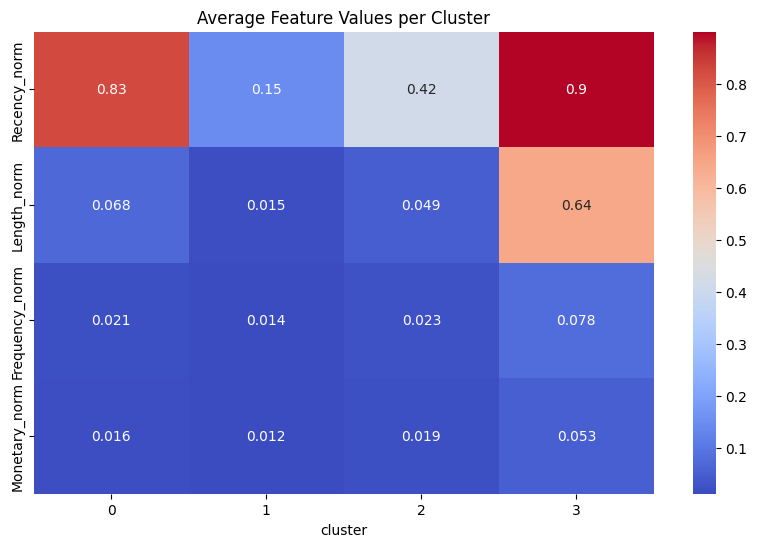

In [24]:
#Heatmap for Feature Correlations per cluster
plt.figure(figsize=(10,6))
sns.heatmap(df_cleaned.groupby("cluster")[['Recency_norm', 'Length_norm', 'Frequency_norm', 'Monetary_norm']].mean().T, cmap="coolwarm", annot=True)
plt.title("Average Feature Values per Cluster")
plt.show()

#### Sample size

In [25]:
p0 = 0.046
p1 = 0.056
alpha = 0.05
power = 0.8
# Calculate effect size
effect_size = sms.proportion_effectsize(p0, p1)
# Compute sample size per group
analysis = sms.NormalIndPower()
sample_size = analysis.solve_power(effect_size, power=power, alpha=alpha, ratio=1)
print(f"Sample size per group: {int(sample_size)}")

Sample size per group: 7579


In [26]:
# Group by Cabin and Segment, then sort by count
value_counts_1 = (
    df_cleaned.groupby(['Cabin', 'segment'])
    .size()
    .reset_index(name='Customer Count')
    .sort_values(by='Customer Count', ascending=False)
)

# Group by Origin and Segment, then sort by count
value_counts_2 = (
    df_cleaned.groupby(['Origin', 'segment'])
    .size()
    .reset_index(name='Customer Count')
    .sort_values(by='Customer Count', ascending=False)
)

# Group by Destination and Segment, then sort by count
value_counts_3 = (
    df_cleaned.groupby(['Destination', 'segment'])
    .size()
    .reset_index(name='Customer Count')
    .sort_values(by='Customer Count', ascending=False)
)

# Display the sorted results
print("Cabin & Segment Counts:\n", value_counts_1)
print("\nOrigin & Segment Counts:\n", value_counts_2)
print("\nDestination & Segment Counts:\n", value_counts_3)
value_counts_3


Cabin & Segment Counts:
       Cabin                        segment  Customer Count
4   Economy              At Risk Explorers           55708
6   Economy         Potential Loyal Flyers           47785
5   Economy  High Value Frequent Customers           42143
7   Economy              Premium customers            7535
2  Business         Potential Loyal Flyers            5385
1  Business  High Value Frequent Customers            4597
0  Business              At Risk Explorers            4514
3  Business              Premium customers            1883

Origin & Segment Counts:
     Origin                        segment  Customer Count
418    NBO              At Risk Explorers           26933
420    NBO         Potential Loyal Flyers           24906
419    NBO  High Value Frequent Customers           22125
381    MBA              At Risk Explorers            6411
383    MBA         Potential Loyal Flyers            4594
..     ...                            ...             ...
509    TET 

,Destination,segment,Customer Count
563,NBO,At Risk Explorers,29142
565,NBO,Potential Loyal Flyers,24865
564,NBO,High Value Frequent Customers,22463
491,MBA,At Risk Explorers,5483
566,NBO,Premium customers,4450
...,...,...,...
738,VNS,High Value Frequent Customers,1
739,VNS,Potential Loyal Flyers,1
740,VNX,Premium customers,1
741,VTE,Potential Loyal Flyers,1


#### Route Analysis by Segmnt

In [27]:
# Step 1: Create the Route column
df_cleaned['Route'] = df_cleaned['Origin'] + ' → ' + df_cleaned['Destination']

# Step 2: Aggregate route-level metrics by Segment and Route
route_analysis = df_cleaned.groupby(['segment', 'Route']).agg(
    Trip_Count=('UNIQUEKEY', 'count'),            # Count of bookings or customers
    Total_Revenue=('Monetary', 'sum'),          # Total fare collected
    Avg_Revenue_Per_Trip=('Monetary', 'mean')   # Average fare per trip
).reset_index()

# Step 3: Loop through each segment and print top 10 routes
for segment in sorted(df_cleaned['segment'].unique()):
    print(f"\n--- Top Routes for Segment {segment} ---")
    top_routes = route_analysis[route_analysis['segment'] == segment]
    top_routes_sorted = top_routes.sort_values(by='Trip_Count', ascending=False).head(10)
    print(top_routes_sorted[['Route', 'Trip_Count', 'Total_Revenue', 'Avg_Revenue_Per_Trip']])



--- Top Routes for Segment At Risk Explorers ---
         Route  Trip_Count  Total_Revenue  Avg_Revenue_Per_Trip
475  MBA → NBO        6189     1877885.08            303.423021
534  NBO → MBA        5242     1651768.24            315.102678
523  NBO → JNB        2481     2628830.30           1059.584966
418  JNB → NBO        2219     2559240.07           1153.330361
329  EBB → NBO        2143     1053899.85            491.787144
143  BOM → NBO        2130     1398861.43            656.742455
237  DAR → NBO        1839      832570.77            452.730163
527  NBO → KIS        1824      428680.11            235.021990
512  NBO → EBB        1770     1025803.37            579.549927
430  KIS → NBO        1714      379019.68            221.131669

--- Top Routes for Segment High Value Frequent Customers ---
          Route  Trip_Count  Total_Revenue  Avg_Revenue_Per_Trip
993   MBA → NBO        4313     1749344.80            405.598145
1048  NBO → MBA        3838     1340670.95            

In [28]:
segment = 'Potential Loyal Flyers'  # replace with the segment number you want to analyze

print(f"\n--- Top Routes for Segment {segment} ---")
top_routes = route_analysis[route_analysis['segment'] == segment]
top_routes_sorted = top_routes.sort_values(by='Trip_Count', ascending=False).head(10)
print(top_routes_sorted[['Route', 'Trip_Count', 'Total_Revenue', 'Avg_Revenue_Per_Trip']])


--- Top Routes for Segment Potential Loyal Flyers ---
          Route  Trip_Count  Total_Revenue  Avg_Revenue_Per_Trip
1588  MBA → NBO        4389     2091111.00            476.443609
1648  NBO → MBA        3938     1858312.88            471.892555
1517  JNB → NBO        2664     4118828.46           1546.106779
1637  NBO → JNB        2583     4063387.76           1573.127278
1421  EBB → NBO        2119     1644348.57            776.002157
1626  NBO → EBB        1917     1495635.05            780.195644
1619  NBO → DAR        1536     1090142.02            709.727878
1329  DAR → NBO        1507     1163889.93            772.322449
1720  ZNZ → NBO        1358     1737819.44           1279.690309
1641  NBO → KIS        1287      405529.44            315.096690


In [29]:
# Load your CSV files
df_all = pd.read_csv('segmentation.csv')              # Main customer dataset
df_consent = pd.read_csv('data/consent.csv')      # Customers who gave consent

# Tag consented records
df_all['Consent_Status'] = df_all['Email'].isin(df_consent['Email']).map({True: 'Consented', False: 'Not Consented'})
df_all

C:\Users\lynn.oloo\AppData\Local\Temp\ipykernel_27808\1090706980.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_consent = pd.read_csv('data/consent.csv')      # Customers who gave consent


,UNIQUEKEY,Full_Name,Phone_No,Email,Cabin,Origin,Destination,Last_Purchase_Date,First_Purchase_Date,Frequency,...,Monetary_norm,R,L,F,M,LRFM Score,CLV,cluster,segment,Consent_Status
0,18741222MOROGOLULEI,MOROGO LULEI,254723772315,riftventurestravelsafaris@gmail.com,Economy,EDL,NBO,2024-12-14,2024-12-14,1,...,0.000428,1,1,1,1,1111,0.018173,1,At Risk Explorers,Consented
1,1875103SALADBORUGURACHA,SALAD BORU GURACHA,254700359516,armyner2003@gmail.com,Economy,MBA,NBO,2025-02-17,2025-02-17,1,...,0.001469,3,1,1,1,1311,0.108641,2,Potential Loyal Flyers,Not Consented
2,1875222MERCYLYNATECHEPKIRUI,MERCYLYNATE CHEPKIRUI,254723379543,xtinekendele@gmail.com,Economy,MBA,NBO,2025-03-01,2025-03-01,1,...,0.001239,3,1,1,1,1311,0.125191,2,Potential Loyal Flyers,Not Consented
3,187534MARIANAUDE,MARIA NAUDE,27825634096,miana@technvst.co,Economy,NBO,ZNZ,2024-12-05,2024-12-05,1,...,0.002417,1,1,1,1,1111,0.006414,1,At Risk Explorers,Not Consented
4,1875429DUNCANOTTOMA,DUNCAN OTTOMA,254723478695,otomaduncan@gmail.com,Economy,NBO,MBA,2025-04-23,2025-04-23,1,...,0.001545,4,1,1,1,1411,0.198763,0,High Value Frequent Customers,Not Consented
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169545,20241113JONATHANGATHIA,JONATHAN GATHIA,254718876522,travel@dreamzworldgroup.com,Economy,MBA,NBO,2024-12-13,2024-12-02,2,...,0.003687,1,4,2,2,4122,0.031192,1,At Risk Explorers,Not Consented
169546,2024122JONATHANNDUNGU,JONATHAN NDUNGU,254718876522,travel@dreamzworldgroup.com,Economy,NBO,MBA,2024-12-13,2024-12-02,2,...,0.003687,1,4,2,2,4122,0.031192,1,At Risk Explorers,Not Consented
169547,2024327ALTAFFARIDUNABDALLA,ALTAF FARIDUN ABDALLA,254722516652,altaf.abdalla@uniquegroup.co.ke,Economy,DAR,NBO,2025-04-24,2025-04-24,2,...,0.004238,4,1,2,2,1422,0.205750,0,High Value Frequent Customers,Not Consented
169548,2024515ATAARSLANKARA,ATA ARSLAN KARA,255767159610,chefalikara@yahoo.com,Economy,DAR,NBO,2024-12-05,2024-12-05,2,...,0.003718,1,1,2,2,1122,0.011514,1,At Risk Explorers,Not Consented


In [30]:
# Filter only consented customers
df_consented = df_all[df_all['Consent_Status'] == 'Consented']

# Group by Segment and count
segment_counts = df_consented['segment'].value_counts().reset_index()
segment_counts.columns = ['Segment', 'Number_of_Customers']

# Display the result
print("✅ Number of customers in each segment (Consented only):\n")
print(segment_counts)

✅ Number of customers in each segment (Consented only):

                         Segment  Number_of_Customers
0              At Risk Explorers                 8353
1  High Value Frequent Customers                 7760
2         Potential Loyal Flyers                 7678
3              Premium customers                 1951


#### Random Sampling

In [33]:
# Function to split a segment into two equal groups from a 50% sample
def split_segment(df, segment_name, seed=42):
    segment_df = df[df['segment'] == segment_name]

    # Sample 50% of the segment
    sampled_df = segment_df.sample(frac=0.5, random_state=seed)

    # Shuffle and reset index
    sampled_df = sampled_df.sample(frac=1, random_state=seed).reset_index(drop=True)

    # Calculate midpoint
    mid_index = len(sampled_df) // 2

    # Split into treatment and control
    treatment = sampled_df.iloc[:mid_index]
    control = sampled_df.iloc[mid_index:]

    # Return only the required columns
    return treatment[['Full_Name', 'Phone_No', 'Email']], control[['Full_Name', 'Phone_No', 'Email']]

# Apply to Premium customers
treatment_premium, control_premium = split_segment(df_consented, 'Premium customers')

# Apply to At Risk Explorers
treatment_risk, control_risk = split_segment(df_consented, 'At Risk Explorers')

# Save the filtered columns to CSV
treatment_premium.to_csv('premium_treatment.csv', index=False)
control_premium.to_csv('premium_control.csv', index=False)
treatment_risk.to_csv('atrisk_treatment.csv', index=False)
control_risk.to_csv('atrisk_control.csv', index=False)

print("✅ All 4 filtered files (with Full_Name, Phone_No, Email) successfully created.")


✅ All 4 filtered files (with Full_Name, Phone_No, Email) successfully created.


In [3]:
import pandas as pd

import numpy as np
 
# Read the data

df = pd.read_csv('April-June 25.csv')
 
# Remove duplicates based on email to ensure distinct emails

df_unique = df.drop_duplicates(subset=['EMAIL_ADDRESS'], keep='first')
 
# Define route classification function

def classify_route(origin, dest):

    african_airports = ['ADD', 'NBO', 'LOS', 'ACC', 'DKR', 'ABV', 'KGL', 'EBB', 'DAR', 'JNB', 'CPT', 'DUR', 'CAI', 'TUN', 'ALG', 'CAS', 'CMN']

    if origin == dest or (origin in african_airports and dest in african_airports):

        return 'Domestic'

    elif origin in african_airports or dest in african_airports:

        return 'Other African countries'

    else:

        return 'International(Not Africa)'
 
# Apply route classification

df_unique['route_type'] = df_unique.apply(lambda x: classify_route(x['ORIGIN'], x['DEST']), axis=1)
 
# Define sampling targets

targets = {

    ('Domestic', 'Business'): 270,

    ('Domestic', 'Economy'): 630,

    ('Other African countries', 'Business'): 360,

    ('Other African countries', 'Economy'): 840,

    ('International(Not Africa)', 'Business'): 270,

    ('International(Not Africa)', 'Economy'): 630

}
 
# Sample data

sampled_dfs = []

for (route, cabin), target in targets.items():

    subset = df_unique[(df_unique['route_type'] == route) & (df_unique['CABINCLASS'] == cabin)]

    if len(subset) >= target:

        sampled = subset.sample(n=target, random_state=42)

    else:

        sampled = subset  # Take all available if less than target

    sampled_dfs.append(sampled)
 
# Combine all samples

final_sample = pd.concat(sampled_dfs, ignore_index=True)
 
# Save to Excel

final_sample.to_excel('sampled_data.xlsx', index=False)
 
print(f"Sampling complete! Total records: {len(final_sample)}")

print("\nDistribution:")

print(final_sample.groupby(['route_type', 'CABINCLASS']).size())

 

C:\Users\lynn.oloo\AppData\Local\Temp\ipykernel_20240\3723106238.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique['route_type'] = df_unique.apply(lambda x: classify_route(x['ORIGIN'], x['DEST']), axis=1)


Sampling complete! Total records: 2853

Distribution:
route_type                 CABINCLASS
Domestic                   Business      270
                           Economy       630
International(Not Africa)  Business      123
                           Economy       630
Other African countries    Business      360
                           Economy       840
dtype: int64


In [2]:
pip install openpyxl


   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpyxl]
   -------------------- ------------------- 1/2 [openpy

In [4]:


# Extract the first 1000 rows
df_sample = df.head(1000)

# Optional: Save the sample to a new CSV file
df_sample.to_csv('sample_1000_records.csv', index=False)

print("✅ Extracted 1000 records.")


✅ Extracted 1000 records.
